In [1]:
import numpy as np
import cvxpy as cp
import scipy as sp
import math

In [2]:
!mkdir -p /root/mosek/

**Abstract**:

In the realm of optimization, the pursuit of optimal solutions among feasible options is central. Typically, optimization involves maximizing or minimizing a function while adhering to specified constraints, a fundamental concept applied across fields such as economics, engineering, and computer science. Among the various optimization categories, convex optimization stands out as particularly potent. It revolves around optimizing convex functions over convex sets, benefiting from the property that local extrema are also global extrema, simplifying optimization using methods like gradient descent. Another notable type is semidefinite programming (SDP), a subset of convex optimization, where linear objective functions are optimized subject to linear constraints, alongside the requirement that the decision variables' symmetric matrix is positive semidefinite—a convex constraint. While real-world problems seldom adhere strictly to convexity, recent advancements showcase how transforming nonconvex functions into SDP problems yields accurate lower bounds. Furthermore, we can tighten the gap between the solution to the original problem and the solution to the SDP by using a new algorithm discovered recently. We demonstrate this algorithm "Autotight" on a toy problem below.

**Problem**:

 The pedagogical problem we seek to solve is
\begin{equation} \tag{1}
\min_{\theta} \sum_{i=1}^{N}\bigg(\frac{1}{\theta - a_{i}}\bigg)^{2},
\end{equation}
where $a_{i}$ is known.


Let's begin by working our way up and examining optimization problems of the form
\begin{equation} \tag{2}
\min_{\theta \in \mathbb{R}^{d}} \{c(\theta)|h_{i}(\theta)=0, \; i \in [N_{h}]\},
\end{equation}
where $\theta$ is the decision variable, c(·) is the cost function, and $h_{i}$(·) are equality constraints. We can "lift" this function to a quadratically constrained quadratic program, in which the cost and contraint functions are quadratic. This turns equation 2 into
\begin{equation} \tag{3}
    \min_{x \in \mathbb{R}^{N}} \{f(x) | g_{i}(x) = 0, l_{j}(x) = 0, i \in [N_{h}], j \in [N_{l}]\},
\end{equation}
where f and $g_{i}$ are quadratic in the lifted vector x, and where the lifted vector is given by
\begin{equation*}
    x^{T} = \begin{bmatrix}
        1 & \theta^{T} & z_{1} & \dots & z_{N_{l}}
    \end{bmatrix},
\end{equation*}
where $z_{i}$ = $l_{i}(\theta)$ := $\frac{1}{\theta - a_{i}}$. Notice we can write f(x) in equation 1 as
\begin{equation*}
    f(x) = \sum_{i = 1}^{N} x_{2 + i}^{2}.
\end{equation*}
Furthermore, now that the functions in equation 3 are quadratic, we can rewrite the equation as
\begin{equation} \tag{4}
    \min_{x \in \mathbb{R}^{N}} \{x^{T}Qx | x^{T}A_{i}x = 0, i \in [N_{A}]\},
\end{equation}
where Q is the cost matrix, $A_{i}$, $i \in [N_{A}]$ are the constraint matrices, and $N_{A} = N_{l} + N_{h}$. For equation 1 specifically, the cost and constraint matrices are 0 for all values except for $Q[i, i] = 1$ for $i = 3, \dots, N + 2$, $A_{i}[1, 2 + i] = A_{i}[2 + i, 1] = -a_{i}$, and $A_{i}[2, 2 + i] = A_{i}[2 + i, 2] = 1$. In other words,
\begin{equation}
Q =
 \begin{bmatrix}
 0 & 0 & 0 & \dots & 0\\
 0 & 0 & 0 & \dots & 0\\
 0 & 0 & 1 & \dots & 0\\
 0 & 0 & 0 & \ddots & \vdots\\
 0 & 0 & 0 & \dots & 1
 \end{bmatrix},\\
 A_{1} =
 \begin{bmatrix}
 0 & 0 & -a_{1} & 0 & \dots & 0\\
 0 & 0 & 1 & 0 & \dots & 0\\
 -a_{1} & 1 & 0 & 0 & \dots & 0\\
 0 & 0 & 0 & 0 & \dots & 0\\
 \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
 0 & 0 & 0 & 0 & 0 & 0
 \end{bmatrix},\\
A_{2} =
 \begin{bmatrix}
 0 & 0 & 0 & -a_{2} & 0 & \dots & 0\\
 0 & 0 & 0 & 1 & 0 & \dots & 0\\
 0 & 0 & 0 & 0 & 0 & \dots & 0\\
 -a_{2} & 1 & 0 & 0 & 0 & \dots & 0\\
 0 & 0 & 0 & 0 & 0 & \dots & 0\\
 \vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
 0 & 0 & 0 & 0 & 0 & 0 & 0
 \end{bmatrix}
\end{equation}
and so on.

Equation 4 is NP-Hard, so we introduce a common strategy to "relax" this problem to a semidefinite programming (SDP) problem. Let X := $xx^{T}$, where X is positive semidefinite $X \succcurlyeq 0$ and rank(X) = 1. We can then solve the following SDP,
\begin{equation} \tag{5}
    \min_{X \in S_{+}^{N}} \{ \langle Q, X \rangle |\langle A_{i}, X \rangle = 0, i \in [N_{A}] \},
\end{equation}
where $\langle \cdot, \cdot \rangle$ is the inner product defined by multiplying the matrices together and taking the trace of the resulting matrix. Equation 5 is the primal relaxation of equation 4, where we relax the nonconvex rank(X) = 1 constraint. This is the equation we now seek to solve for the toy problem.

We know that a solution X* is optimal if the rank(X) = 1. We call this "rank tight," and from rank-tightness of the SDP relaxation, we can deduce "strong duality," where the lower bound we find is indeed the global minimum on the function.

We demonstrate the above technique with code as follows:


In [3]:
#Pedagogical problem before Autotight
n = 3
a_array = np.array([4, 15, 2])
np.random.seed(5)

#Q matrix (cost)
Q_mat = np.zeros([n+2, n+2])
for i in range(2, n+2):
  Q_mat[i, i] = 1

#A_i matrices (constraint)
#n matrices, each (n+2)x(n+2)
A = np.zeros([n, n+2, n+2])

#for each matrix
for i in range(n):
  A[i, 0, 2+i] = A[i, 2+i, 0] = -a_array[i]
  A[i, 1, 2+i] = A[i, 2+i, 1] = 1

#defining decision variable, objective, and constraints
X = cp.Variable((n+2, n+2), symmetric=True)
#X is PSD
constraints = [X >> 0]
constraints += [
        cp.trace(A[i] @ X) == 0 for i in range(n)
        ]

prob = cp.Problem(cp.Minimize(cp.trace(Q_mat @ X)),
                  constraints)
prob.solve(solver=cp.MOSEK, verbose = False)

eigenvalues = sorted(np.linalg.eigvals(X.value), reverse = True)
print("The optimal value is", prob.value)
print("A solution X is\n", X.value)
print("using X, the sum is", np.sum([(1 / math.sqrt((X.value[1,1])) - a_array[i]) ** 2 for i in range(n)]))
print("Ratio between two largest eigenvalues of X*: ", eigenvalues[0] / eigenvalues[1])

SolverError: The solver MOSEK is not installed.

From running the code, we see that the solution is not rank tight, and rank($X^*$) does not equal 1.

In the below figure, we visualize a generic function, its SDP relaxation, and its Lagrangian dual. In this figure, $\: d^{*}$ is the Lagrandian dual of the SDP, $\; p^{*}$ is the solution to the relaxed SDP, and $\; q^{*}$ is the solution to the original function.

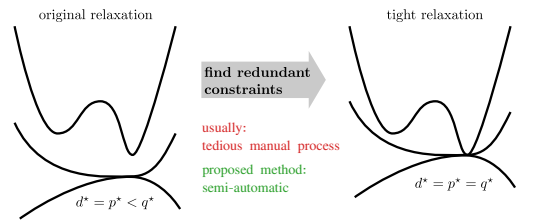

In the above implementation, the gap between the solution to the SDP $p^{*}$ and the solution to the original optimization problem $q^{*}$ is not tight. Our goal is the decrease this gap and therefore increase the tightness of the solution. We can accomplish this by reducing the rank of $X^*$, and we can accomplish this by adding "redundant constraints" to the problem. These constraints are redundant in the QCQP, but may change the feasible region of the SDP. In particular, they may reimpose structure lost by relaxing the rank-one constraint. By reducing the rank of the matrix, we improve the tightness of the solution. However, finding these redundant constraints can be difficult and tedious manual process, so we introduce the Autotight algorithm, which seeks to find these constraints through a semi-automatic process.


**The Autotight Algorithm**


The idea behind Autotight is that all of the constraint matrices $A_{i}$ are in the nullspace of the linear subspace spanned by the feasible points. We first generate feasible samples $\theta^{(s)}$, and with these samples we can create lifted samples $\chi = \{x^{(1)}, \dots, x^{(N_{s})} \}$, with $x^{s}$ created using the known lifting function. We then have
\begin{equation*}
    \langle A_{i}, X^{(s)} \rangle = 0,
\end{equation*}
where $X^{(s)} = x^{(s)}x^{(s)^{T}}$. We can then formulate our data matrix Y as
\begin{equation*}
    Y = [\text{vech}(X^{(1)}) \dots \text{vech}(X^{N_{s}})] \in \mathbb{R}^{n x N_{s}}.
\end{equation*}
Our learned redundant constraints $A_{l}$ that we seek to find are in the left nullspace of our data matrix Y.
\begin{equation*}
    A_{l} = \{A_{1}, \dots, A_{N_{n}} \} = \{\text{vech}^{-1}(a_{i}) | a_{i}^{T}Y = 0\}
\end{equation*}
We can calculate this nullspace basis using a QR decomposition, which induces sparsity, leading to lower memory and time consumption and increased interpretability. The vectors in the null of Q of the QR factorization on Y are our learned constraints, and we can add them to the constraints to induce rank-tightness.

In [ ]:
#Autotight Algorithm

#half vectorization function
def vech(matrix):
     if len(matrix) != len(matrix[0]):
         raise ValueError("not a square matrix")
     rows = int((len(matrix)*(len(matrix)+1))/2)
     newVec = np.zeros([rows, 1])
     index = 0
     for col in range(len(matrix[0])):
         for row in range(col + 1):
             if row == col:
                 newVec[index][0] = matrix[row][col] / math.sqrt(2)
                 index += 1
             else:
                 newVec[index][0] = matrix[row][col]
                 index += 1
     return newVec

#inverse half vectorization, which creates a symmetric matrix
def inv_vech(vech):
    vech_flat = vech.flatten()
    n = len(vech_flat)
    mat_size = int(math.sqrt(2 * n + (1/4)) - (1/2))

    A = populateUpperTri(mat_size, vech_flat)
    A = A + A.T
    np.fill_diagonal(A, np.diagonal(A) / 2)
    return A

def populateUpperTri(mat_size, vec):
    A = np.zeros([mat_size, mat_size])
    index = 0
    for col in range(mat_size):
        for row in range(col + 1):
            if row == col:
                A[row][col] = vec[index] * math.sqrt(2)
                index += 1
            else:
                A[row][col] = vec[index]
                index += 1
    return A

#formulates the Y data matrix
def formulateY(N):
    print("N = ", N)
    vech_size = int(N)
    total_pts = int(1.2 * N)
    Y = np.empty([vech_size, 0])
    for i in range(total_pts):
        theta = np.random.rand(1)
        z_vals = 1 / (theta - a_array)
        x_feas = np.hstack(([1], theta, z_vals)) #creates the lifted vector
        Y = np.hstack((Y, vech(x_feas[None, :].T @ x_feas[None, :])))
    return Y

big_N = (n+2)*(n+3)/2
Y = formulateY(big_N)
print("shape of Y: ", Y.shape)

#QR factorization
Q, R = sp.linalg.qr(Y)
learned_constraints = Q[:, np.linalg.matrix_rank(Y) + 1:]
print("learned constraints shape: ", learned_constraints.shape)

Now that we've found the learned redundant constraints, let's add them to the constraints of the problem and solve the problem again.

In [ ]:
#these are the inverse vech of the learned constraint column vectors
constraints.clear()
constraints += [X >> 0]
constraints += [
        cp.trace(inv_vech(learned_constraints[:, i]) @ X) == 0 for i in range(len(learned_constraints[0]))
        ]
constraints += [
        X[0][0] == 1
        ]
prob = cp.Problem(cp.Minimize(cp.trace(Q_mat @ X)),
                  constraints)
prob.solve(solver=cp.MOSEK, verbose = False)


# Print result.
print("The optimal value is", prob.value)
print("A solution X is\n", X.value)
print("using X, the sum is", np.sum([(1 / (X.value[0,1] - a_array[i])) ** 2 for i in range(n)]))

#checking for rank tightness by comparing greatest two eigenvalues
eigenvalues = sorted(np.linalg.eigvals(X.value), reverse = True)
print("Ratio between two largest eigenvalues of X*: ", eigenvalues[0] / eigenvalues[1])

#from matplotlib import pyplot as plt
#plt.spy(inv_vech(learned_constraints[:,0]))


**Solution and implications:**

We determine rank-tightness by finding the ratio of the two largest eigenvalues of the solution $X^{*}$. If this ratio is suffiently large, we say that the solution has rank one. As this solution is rank one, we can say we have rank-tightness, and therefore the lower bound this solution gives is equal to the global minimum of the function.




**Future Considerations:**

The next steps are to vectorize the code. Vectorizing the helper functions created above would allow us to take advantage of parallel computing, drastically decreasing time consumption of the code. Additionally, we can continue to build on this code and move onto the Autotemplate, which allows us to generalize Autotight and apply it to other optimization problems. Finally, I can continue to learn more about optimization. This journey immersing myself in research papers and optimization concepts has been a blast, and I am excited to continue this journey!

**References**

Axler, Sheldon. Linear Algebra Done Right. 25 Mar. 2024.

Boyd, Stephen, and Lieven Vandenberghe. Convex Optimization. 2014.

Dümbgen, Frederike, et al. Toward Globally Optimal State Estimation Using Automatically Tightened Semidefinite Relaxations. 8 Sept. 2023.





